<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/FastText_BiLSTM-len64_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet
!pip install gensim==3.8.3 --quiet
# !pip install compress-fasttext==0.0.1 --quiet

In [51]:
!pip install compress-fasttext==0.0.7 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import wget
import os
import sys
import re
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import compress_fasttext
import gensim

# **Get cleaned dataset**

In [53]:
PATH_CLEANED_DATASET = 'data_cleaned_RU_merge_2ch_and_ok.csv'
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET

if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [54]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
128092,наслать уже,0
59154,мой телефон,0
54769,и что если коля ты хреновый житься,0
137072,прикол идиотский неважно кто совершенный она б...,1
261465,ахахахах вголос проорать,1
65381,расчистить нереально,0
224424,кастрировать чтобы такой большой нерождаться,1
235696,в китай государственный чиновник за воровство ...,0
22240,здравствуйте вы там работать,0
71235,вчера укол сделать до сей пора болеть почему м...,0


In [55]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 6728
min : 1
mean : 75.5010886860397


max:  890
min:  0
mean:  11.992447716423932


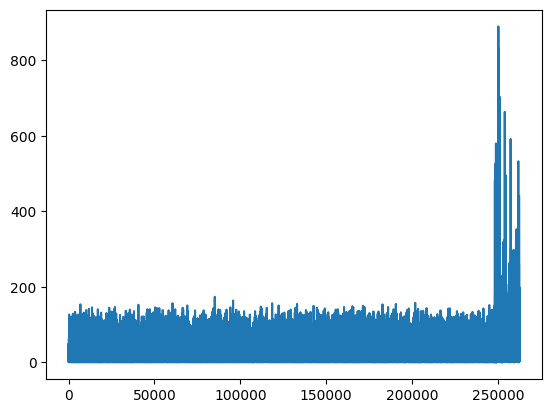

In [56]:
print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [57]:
sentences = df.comment.values
labels = df.toxic.values

In [91]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
print(X_train.shape)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42) # .1764705882352941   .25
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(210161,)
(210161,)
(26270,)
(26271,)


In [59]:
# X_train=X_train[:10]
# y_train=y_train[:10]
# X_val=X_val[:10]
# y_val=y_val[:10]
# X_test=X_test[:10]
# y_test=y_test[:10]

In [60]:
X_train.shape

(210161,)

[FastText Embedding by David Dale](https://github.com/avidale/compress-fasttext/releases/tag/v0.0.1)

In [61]:
import compress_fasttext
# url = 'https://github.com/avidale/compress-fasttext/releases/download/v0.0.1/ft_freqprune_100K_20K_pq_300.bin'

# print(small_model['спасибо'])
# # [ 0.26762889  0.35489027 ...  -0.06149674] # a 300-dimensional vector
# print(small_model.most_similar('котенок'))


# import fasttext
url = 'https://github.com/avidale/compress-fasttext/releases/download/v0.0.1/ft_freqprune_100K_20K_pq_300.bin'
PATH_FASTTEXT = 'ft_freqprune_100K_20K_pq_300.bin'



if not os.path.exists(PATH_FASTTEXT):
    wget.download(url)
    
# ft = fasttext.load_model('ft_freqprune_100K_20K_pq_300.bin')

ft = gensim.models.fasttext.FastTextKeyedVectors.load('ft_freqprune_100K_20K_pq_300.bin')
print(ft['jhsfbjhsg'].shape)


(300,)


In [62]:
PAD_TOKEN = '<pad>'

In [63]:
def vectorize_sentence(sentence: str, vectorizer=ft, pad_token = PAD_TOKEN, max_sequence_length=30) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [vectorizer.get_vector(t) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [vectorizer[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

In [64]:
sequence_length=64

# Word Vectorizer

In [65]:
# X_train = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=ft,
#         pad_token = PAD_TOKEN,
#         max_sequence_length=sequence_length),
#     X_train.flatten()
#     )
# ))

# X_val = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=ft,
#         pad_token = PAD_TOKEN,
#         max_sequence_length=sequence_length),
#     X_val.flatten()
#     )
# ))

# X_test = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=ft,
#         pad_token = PAD_TOKEN,
#         max_sequence_length=sequence_length),
#     X_test.flatten()
#     )
# ))

In [66]:
X_train.shape

(210161,)

In [67]:
ft[PAD_TOKEN].shape[0]

300

In [68]:
DIMENSION_EMBEDDING=ft[PAD_TOKEN].shape[0]

# Build model  BiLSTM

Model: "FASTTEXT-RusVectores_CNN-GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d_1 (Spatia  (None, 64, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 64, 512)          1140736   
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                      

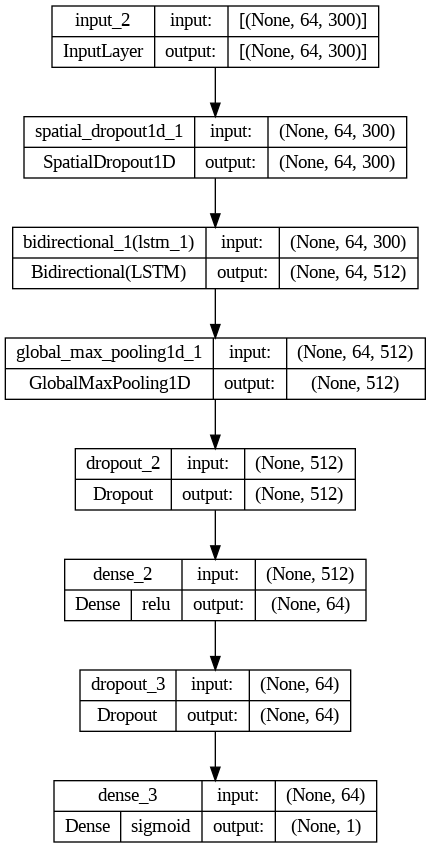

In [69]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Bidirectional,LSTM,SpatialDropout1D,GlobalMaxPool1D
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

SEED = 42
EPOCHS = 21
BATCH_SIZE = 512
MODEL_NAME = 'FASTTEXT-RusVectores_CNN-GRU'

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(256, recurrent_dropout=0.1, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

In [70]:
X_test[:2]

array(['классный фигурка',
       'я уехать по семейный обстоятельство родитель быть пожилой они хотеться на родина дожить себя дом'],
      dtype=object)

In [71]:
import math
class Dataset(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.x))
        batch_x = self.x[low:high]
        batch_y = self.y[low:high]
        ###################

        batch_x = np.array(list(map(
            lambda sentence:vectorize_sentence(
            sentence,
            vectorizer=ft,
            pad_token = PAD_TOKEN,
            max_sequence_length=sequence_length),
        batch_x.ravel()
        )
    ))

        ###################

        return batch_x, batch_y

In [72]:
BATCH_SIZE

512

In [73]:
train_gen = Dataset(x_set=X_train,y_set=y_train,batch_size=BATCH_SIZE)

val_gen = Dataset(x_set=X_val,y_set=y_val,batch_size=BATCH_SIZE)
x,y = train_gen.__getitem__(1)

In [74]:
x.shape

(512, 64, 300)

In [75]:
# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("GC")
        gc.collect()

In [76]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

# history = model.fit(
#     x=X_train,
#     y=y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(X_val,y_val),
#     callbacks=[early_stopping],
#     class_weight=calculate_weights(neutral_count, negative_count),
# )

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stopping,GarbageCollectorCallback()],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/21
411/411 [==============================] - 416s 993ms/step - loss: 0.3899 - tp: 31211.0000 - fp: 25170.0000 - tn: 145579.0000 - fn: 8201.0000 - accuracy: 0.8412 - precision: 0.5536 - recall: 0.7919 - auc: 0.9061 - prc: 0.7442 - val_loss: 0.2488 - val_tp: 4328.0000 - val_fp: 1947.0000 - val_tn: 19359.0000 - val_fn: 637.0000 - val_accuracy: 0.9016 - val_precision: 0.6897 - val_recall: 0.8717 - val_auc: 0.9575 - val_prc: 0.8804
Epoch 2/21
411/411 [==============================] - 410s 997ms/step - loss: 0.2802 - tp: 34142.0000 - fp: 17484.0000 - tn: 153265.0000 - fn: 5270.0000 - accuracy: 0.8917 - precision: 0.6613 - recall: 0.8663 - auc: 0.9523 - prc: 0.8592 - val_loss: 0.1769 - val_tp: 4259.0000 - val_fp: 983.0000 - val_tn: 20323.0000 - val_fn: 706.0000 - val_accuracy: 0.9357 - val_precision: 0.8125 - val_recall: 0.8578 - val_auc: 0.9702 - val_prc: 0.9169
Epoch 3/21
411/411 [==============================] - 398s 967ms/step - loss: 0.2352 - tp: 35117.0000 - fp: 13986.0000 - 

**Save Model**

In [77]:
model.save(MODEL_NAME)

In [92]:
test_gen = Dataset(x_set=X_test,y_set=y_test,batch_size=BATCH_SIZE)

In [78]:
# X_test = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=ft,
#         pad_token = PAD_TOKEN,
#         max_sequence_length=sequence_length),
#     X_test.flatten()
#     )
# ))

In [93]:
probs = model.predict(test_gen).ravel()

52/52 [==============================] - 22s 415ms/step


In [80]:
# threshold =0.5
# pred = np.where(probs<threshold,0,1)

**Model evaluation**

In [94]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def plot_cm(labels, predictions, p=0.5):
  predictions = np.where(predictions <p,0,1)
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 21})
  plt.rc('axes', titlesize=16)
  plt.rc('axes', labelsize=14)
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  # plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.title('Матрица ошибок')
  plt.ylabel('Актуальное значение')
  plt.xlabel('Прогнозируемое значение')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(labels, predictions)))
  print("Recall: {0:.2f} %".format(100 * recall_score(labels, predictions)))
  print("Precision: {0:.2f} %".format(100 * precision_score(labels, predictions)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(labels, predictions)))  
  precision, recall, f1score = precision_recall_fscore_support(labels, predictions, average='macro')[:3]
  print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
  print(classification_report(labels, predictions,digits=4))
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 96.01 %
Recall: 89.83 %
Precision: 89.49 %
F1-score: 89.66 % 

precision: 0.935342624841535, recall: 0.9365879142515732, f1score: 0.9359635936272905
              precision    recall  f1-score   support

           0     0.9758    0.9749    0.9753     21216
           1     0.8949    0.8983    0.8966      5054

    accuracy                         0.9601     26270
   macro avg     0.9353    0.9366    0.9360     26270
weighted avg     0.9602    0.9601    0.9602     26270

True Negatives:  20683
False Positives:  533
False Negatives:  514
True Positives:  4540


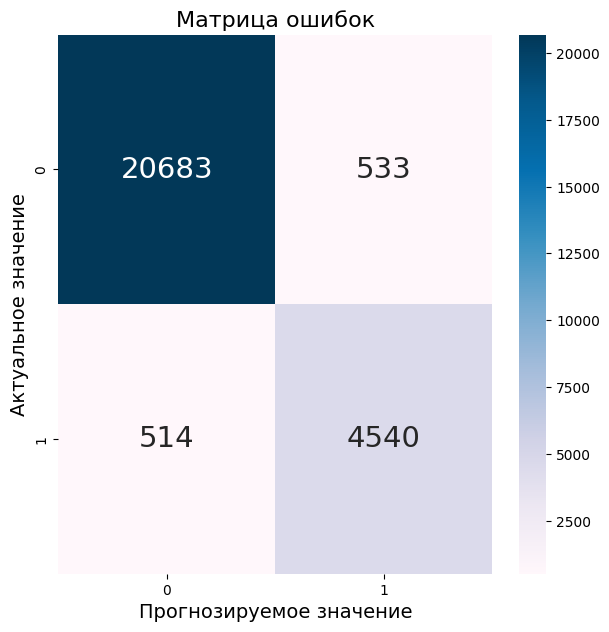

In [97]:
plot_cm(y_test, probs)

In [96]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

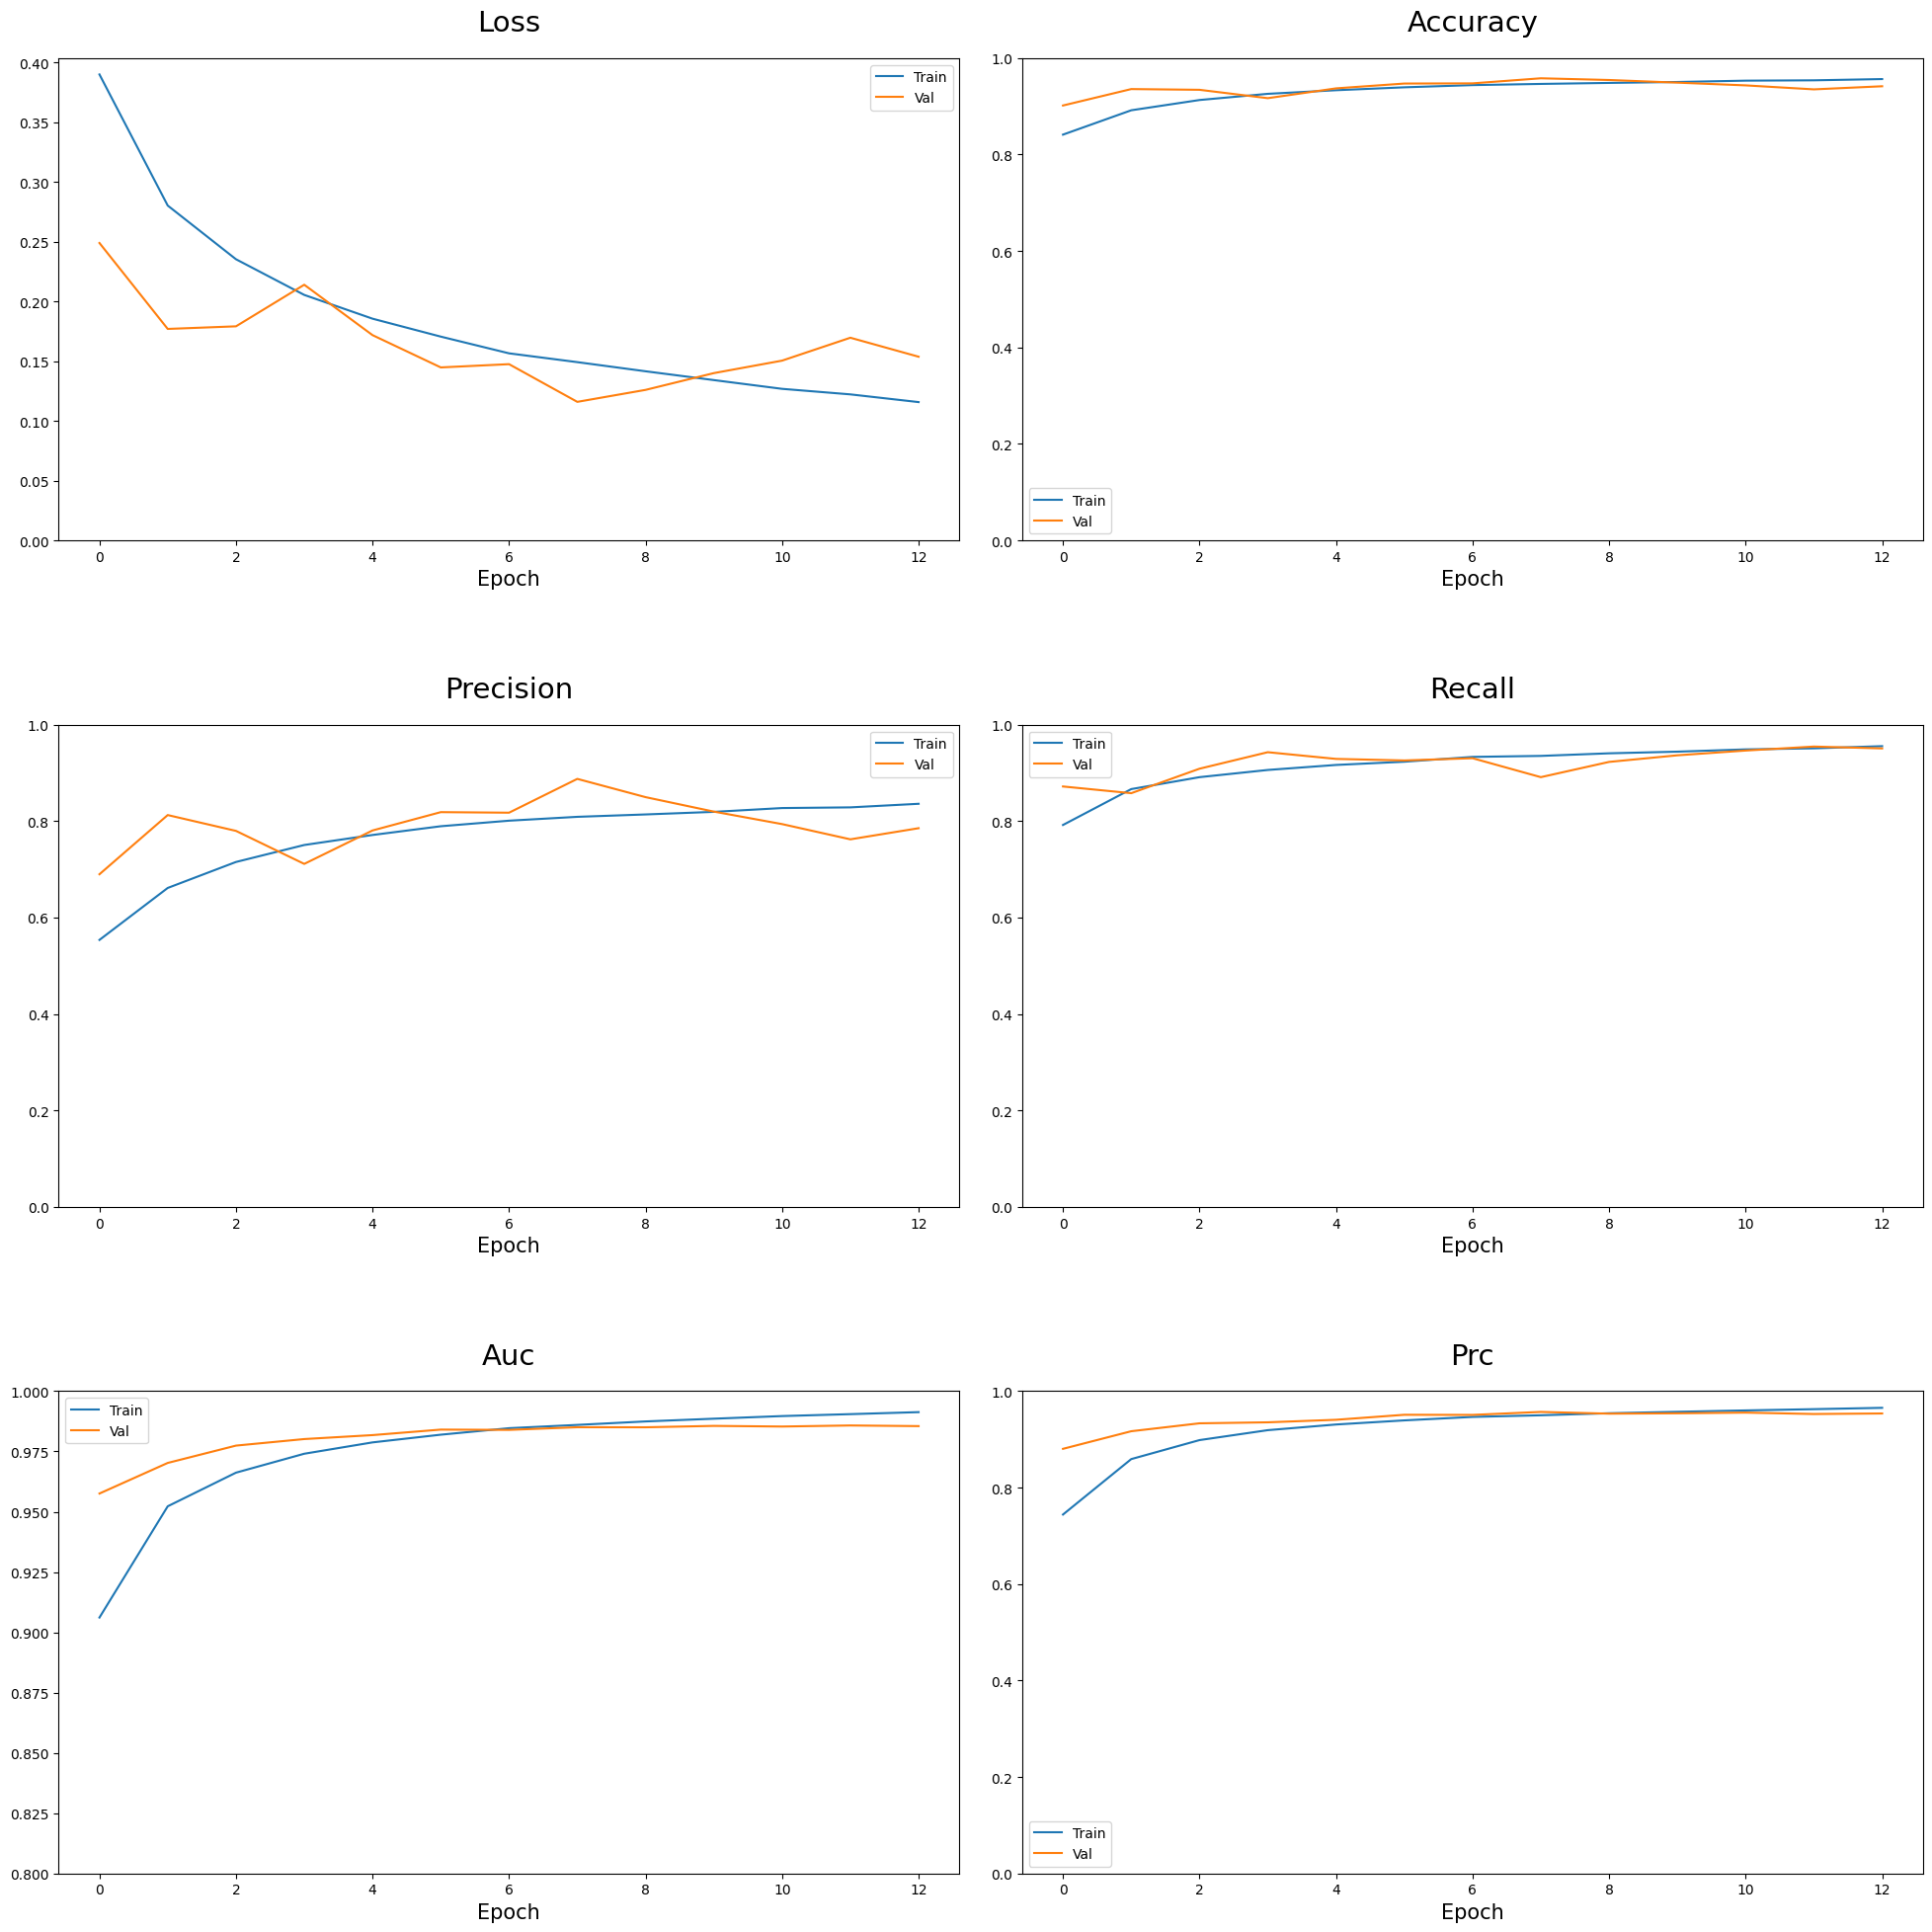

In [98]:
plot_metrics(history)

**Show ROC - curve**

: ROC AUC=0.985
treshold
[1.9999998e+00 9.9999976e-01 9.9999869e-01 ... 1.6829168e-05 1.6817407e-05
 9.1529149e-09]


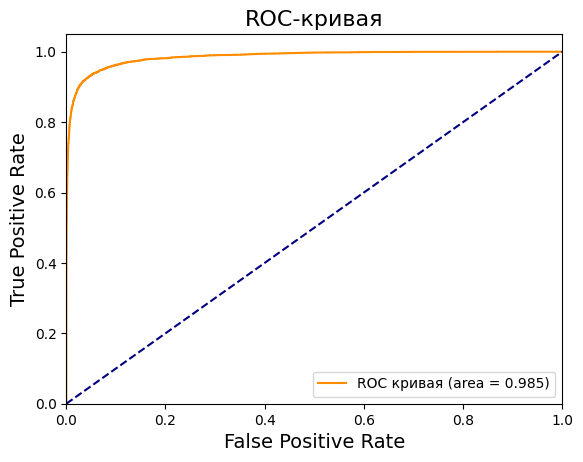

Best F1-Score:  0.898787035195864
Best threshold:  0.5254133
Accuracy: 96.12 %
Recall: 89.43 %
Precision: 90.33 %
F1-score: 89.88 % 

precision: 0.9390834365330081, recall: 0.9357640723026905, f1score: 0.937411972472938
              precision    recall  f1-score   support

           0     0.9749    0.9772    0.9760     21216
           1     0.9033    0.8943    0.8988      5054

    accuracy                         0.9612     26270
   macro avg     0.9391    0.9358    0.9374     26270
weighted avg     0.9611    0.9612    0.9612     26270

True Negatives:  20732
False Positives:  484
False Negatives:  534
True Positives:  4520


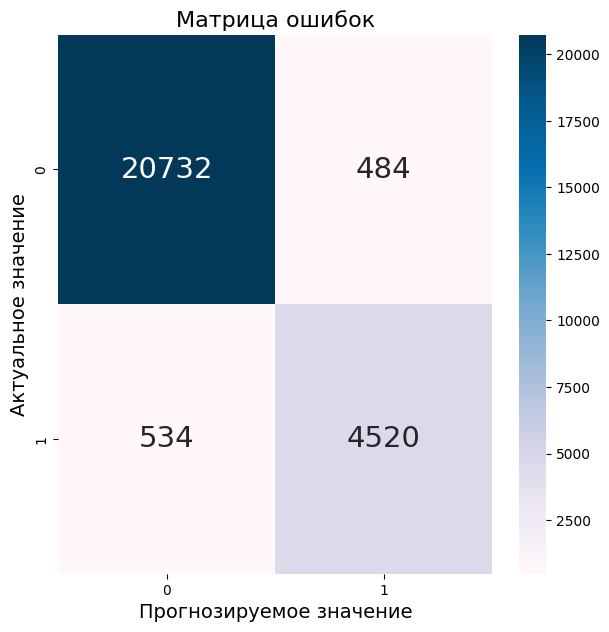

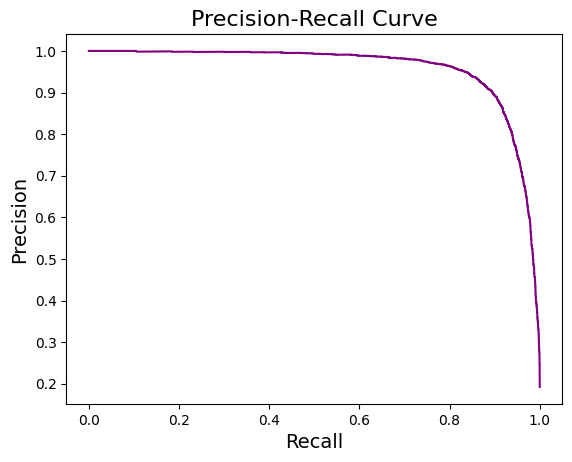

In [99]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
# сохраняем вероятности только для положительного исхода
lr_probs = probs

# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print(': ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

print('treshold')
print(treshold)

# размеры шрифта
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
# строим график
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right",)
plt.show()
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs)
numerator = 2 * recall * precision
denom = recall + precision
f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
max_f1 = np.max(f1_scores)
max_f1_thresh = thresholds[np.argmax(f1_scores)]
print('Best F1-Score: ',max_f1)
print('Best threshold: ',max_f1_thresh)
plot_cm(y_test,lr_probs, p=max_f1_thresh)
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show() 

In [86]:
antiInterr=777+0

In [87]:
antiInterr=777+0

In [ ]:
ghgh=7+8